# Covid-19 
1. Evolução Itália, Espanha e Portugal
2. Comparação entre China e Itália 
3. Número casos, Mortos e Recuperados Portugal e alguns países europeus 

As análises são atualizadas diariamente utilizando dados tratados pelo __Center for Systems Science and Engineering (CSSE) at Johns Hopkins University__ disponiveis em https://github.com/CSSEGISandData/COVID-19

Análise desenvolvida por __Pedro Sobreiro__ e __António Moreira__ professores na Escola Superior de Desporto de Rio Maior e pode ser consultada em https://sobreiro.herokuapp.com/voila/render/analysis/Covid-19.ipynb

In [146]:
# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
import plotly.express as px

import warnings; 
warnings.simplefilter('ignore')

In [147]:
# importing datasets
full_table = pd.read_csv('https://raw.githubusercontent.com/pesobreiro/jupyternotebooks/master/dados/covid.csv',parse_dates=['Date'],index_col=0)


In [148]:
# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values with NA
full_table[['Province/State']] = full_table[['Province/State']].fillna('NA')

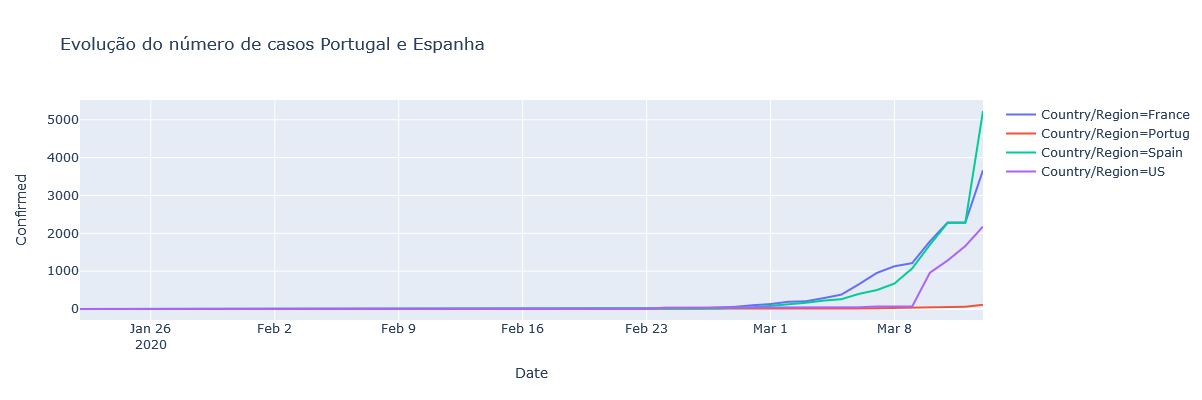

In [149]:
temp = full_table.loc[((full_table['Country/Region']=='Spain')| (full_table['Country/Region']=='Portugal')
                       |(full_table['Country/Region']=='France') |(full_table['Country/Region']=='US'))]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()

temp = temp.reset_index()


fig = px.line(temp, x="Date", y="Confirmed", color='Country/Region',height=400,width=1000,
             title='Evolução do número de casos Portugal e Espanha')
fig.show()

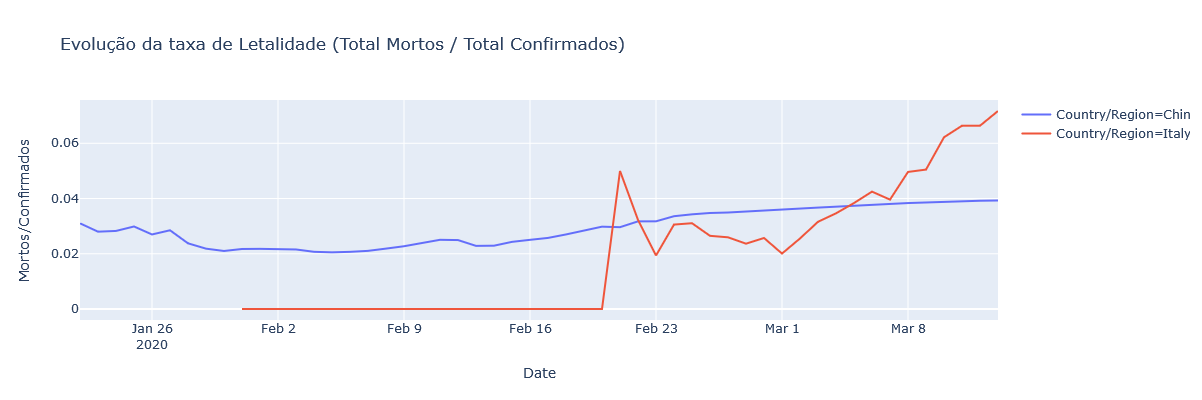

In [150]:
temp = full_table.loc[(full_table['Country/Region']=='Italy') | (full_table['Country/Region']=='China')]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()

temp = temp.reset_index()
temp['Mortos/Confirmados'] = temp['Deaths']/temp['Confirmed']


fig = px.line(temp, x="Date", y="Mortos/Confirmados", color='Country/Region',height=400,width=1000,
             title='Evolução da taxa de Letalidade (Total Mortos / Total Confirmados)')
fig.show()

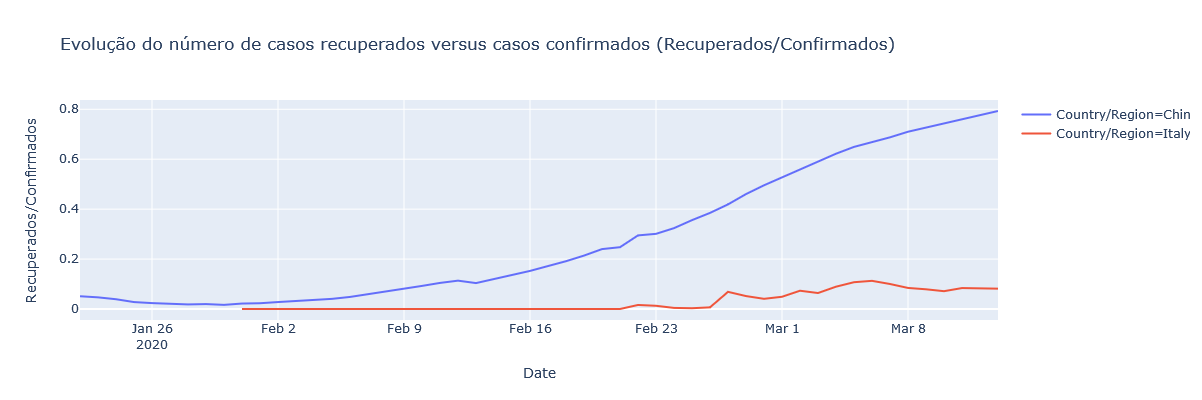

In [151]:
temp['Recuperados/Confirmados'] = temp['Recovered']/temp['Confirmed']

fig = px.line(temp, x="Date", y="Recuperados/Confirmados", color='Country/Region',  height=400,width=1000,
             title='Evolução do número de casos recuperados versus casos confirmados (Recuperados/Confirmados)')
fig.show()

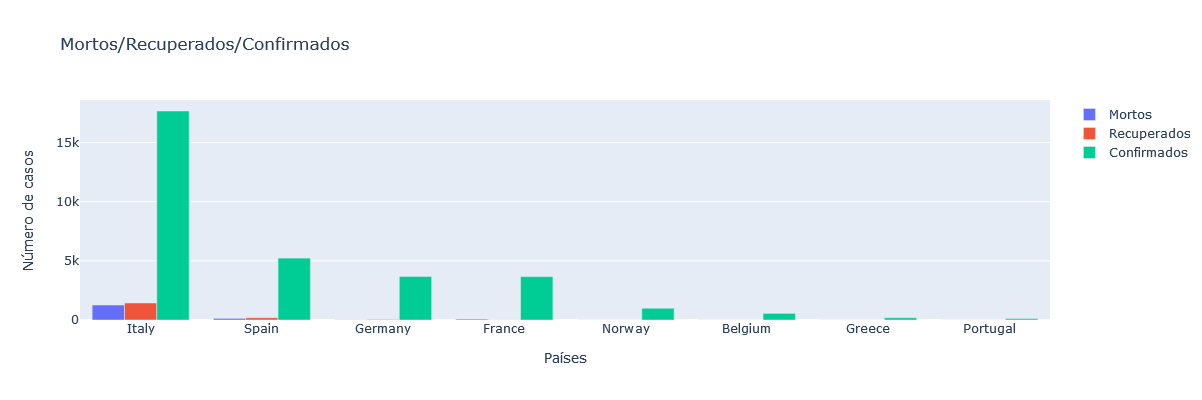

In [152]:
temp = full_table.loc[full_table.Date == full_table.Date.max()]
temp = temp.groupby(['Country/Region'])['Confirmed', 'Deaths', 'Recovered'].sum().sort_values('Confirmed',ascending=False)


europa = ['Italy', 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']

temp=temp.reset_index()
temp=temp.loc[temp['Country/Region'].isin(europa)]


import plotly.graph_objects as go

layout = go.Layout(height=400,width=1000)

fig = go.Figure(data=[
    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
],layout=layout)

fig.update_layout(
    title="Mortos/Recuperados/Confirmados",
    xaxis_title="Países",
    yaxis_title="Número de casos",
)
fig.show()

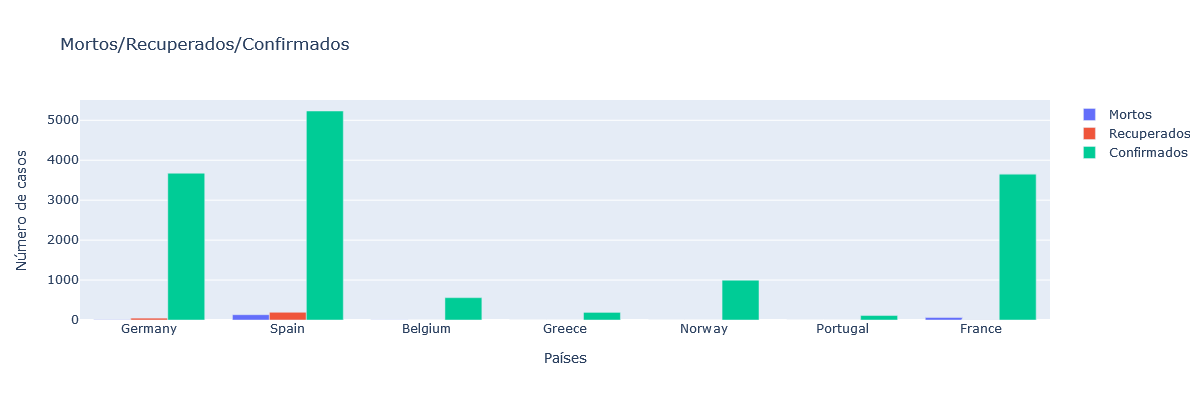

In [153]:
europa = [ 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']
temp=full_table.loc[full_table.Date == full_table.Date.max()]
temp=temp.reset_index()
temp=temp.loc[temp['Country/Region'].isin(europa)]

layout = go.Layout(height=400,width=1000)

fig = go.Figure(data=[
    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
],layout=layout)

fig.update_layout(
    title="Mortos/Recuperados/Confirmados",
    xaxis_title="Países",
    yaxis_title="Número de casos",
)

fig.show()

## Casos portugal
Dados obtidos em https://github.com/aperaltasantos/covid_pt

In [154]:
# importing datasets
dfPortugal = pd.read_csv('https://raw.githubusercontent.com/pesobreiro/jupyternotebooks/master/dados/covid_pt.csv',parse_dates=['date'])

In [155]:
dfPortugal=dfPortugal.fillna(0)

In [156]:
# dfPortugal.columns

In [157]:
dfPortugal.columns = ['data', 'casos_suspeitos', 'casos_suspeitos_novos', 'confirmados', 'confirmados_novos',
       'internados', 'internados_novos', 'cuidadosIntensivos', 'cuidadosIntensivos_novos', 'recuperados','recuperados_novos', 'mortos', 'mortos_novos']

In [158]:
temp = pd.melt(dfPortugal,id_vars='data',
               value_vars=['casos_suspeitos', 'confirmados', 'internados', 'cuidadosIntensivos', 'mortos'])

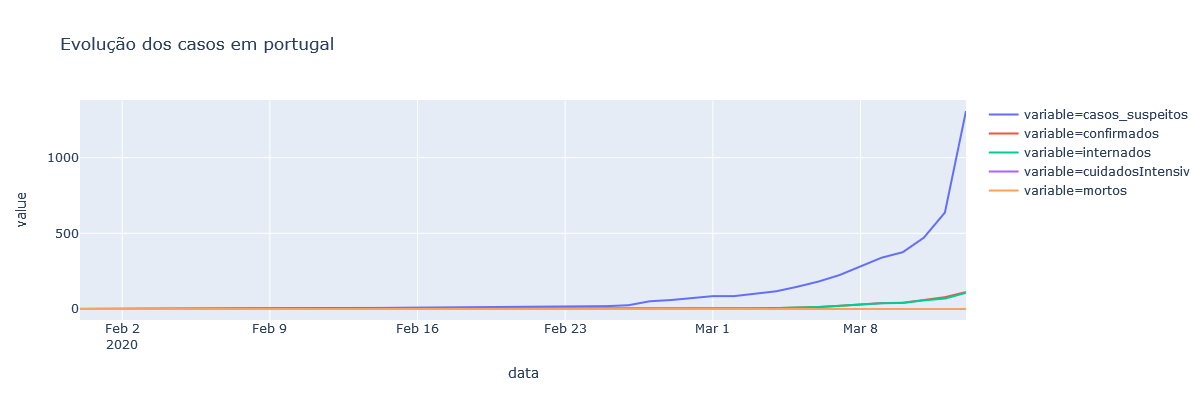

In [159]:
#temp['confirmed'] = temp['Recovered']/temp['Confirmed']

fig = px.line(temp, x="data", y="value", color = 'variable',height=400,width=1000,
             title='Evolução dos casos em portugal')
fig.show()